In [1]:
import pandas as pd
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from flask import Flask, jsonify
from sqlalchemy.engine import url
import json
from sqlalchemy import extract
from sqlalchemy.engine import make_url
import psycopg2
from sqlalchemy.sql import text

In [2]:
# opening configuration file, saving into a variable, then establishing that variable as env which specifies the data as development
# environment credentials


with open('sql/config.json') as datafile:
    data = json.load(datafile)

env = data['dev']


In [3]:
# Instantiating the environment column values as the column names to hide sensitive data

db = env['db']
user = env['user']
password = env['pass']
port = env['port']
host = env['host']

In [4]:
# Connection string

engine = sqlalchemy.create_engine(f'postgresql://{user}:{password}@{host}:{port}/{db}')


In [5]:
# Reflecting an existing DB into a new model
Base = automap_base()

In [6]:

#Trying another method reflecting tables

Base.prepare(autoload_with = engine)

In [7]:
# Seeing what tables there are

Base.classes.keys()

['jhu_cre_cases_deaths', 'location']

In [8]:
# Saving the tables as references here if u want 

location = Base.classes.location

In [9]:
# Another table reference 

jhu_data = Base.classes.jhu_cre_cases_deaths

In [10]:
# Create our session from python to DB
#Create a session object to intiiate query in db

from sqlalchemy.orm import sessionmaker

Session = sessionmaker(bind = engine)
session = Session()

In [11]:
# Test query to make sure database connection works

query = session.query(jhu_data)

In [12]:
#SQL only accepts str vals so have to convert query into string so that its readable by sql, but then we have a df we can
# manipulate however. This should not fail and allow you to do whatever with the data. (No more worries abt csvs etc yay!)

jhucredf = pd.DataFrame(engine.connect().execute(str(query)))

In [13]:
jhucredf

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,1001,19732,230,32.539527,-86.644082,Alabama,Autauga County,55688,55380,20573,...,723,111,49283,779,29291,3953,44884,2450,779,1726
1,1003,69641,724,30.727750,-87.722071,Alabama,Baldwin County,221898,212830,78622,...,2218,887,201483,3994,112058,19748,181512,7322,7322,96747
2,1005,7451,103,31.868263,-85.387129,Alabama,Barbour County,22023,25361,5024,...,220,132,16120,572,8170,2488,13323,2246,836,1629
3,1007,8067,109,32.996421,-87.125115,Alabama,Bibb County,20393,22493,6280,...,346,163,16130,265,8096,2182,14111,1264,305,1142
4,1009,18616,261,33.982109,-86.567906,Alabama,Blount County,57697,57681,18189,...,1038,115,46446,1961,27463,6231,42118,2365,403,4846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,12484,139,41.659439,-108.882788,Wyoming,Sweetwater County,41888,43521,16977,...,502,209,38872,1298,21739,4733,35185,712,879,12817
3138,56039,12123,16,43.935225,-110.589080,Wyoming,Teton County,23390,23280,7250,...,140,771,22267,1777,13028,2970,20372,561,467,5730
3139,56041,6378,43,41.287818,-110.547578,Wyoming,Uinta County,20183,20479,7744,...,322,141,18709,322,10091,2260,18063,686,100,2401
3140,56043,2749,50,43.904516,-107.680187,Wyoming,Washakie County,7738,8027,2601,...,108,77,6948,108,3869,1160,6051,379,15,1903


In [14]:
sql = '''
    SELECT * FROM jhu_cre_cases_deaths;
'''
with engine.connect() as conn:
    query = conn.execute(text(sql))
df = pd.DataFrame(query.fetchall())

In [15]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,1001,19732,230,32.539527,-86.644082,Alabama,Autauga County,55688,55380,20573,...,723,111,49283,779,29291,3953,44884,2450,779,1726
1,1003,69641,724,30.727750,-87.722071,Alabama,Baldwin County,221898,212830,78622,...,2218,887,201483,3994,112058,19748,181512,7322,7322,96747
2,1005,7451,103,31.868263,-85.387129,Alabama,Barbour County,22023,25361,5024,...,220,132,16120,572,8170,2488,13323,2246,836,1629
3,1007,8067,109,32.996421,-87.125115,Alabama,Bibb County,20393,22493,6280,...,346,163,16130,265,8096,2182,14111,1264,305,1142
4,1009,18616,261,33.982109,-86.567906,Alabama,Blount County,57697,57681,18189,...,1038,115,46446,1961,27463,6231,42118,2365,403,4846


In [135]:
import os
data = os.path.join("JHU_Cases_Deaths_with_CRE_Data_2_0.csv")

df = pd.read_csv(data)

df.columns

Index(['fips', 'cases', 'deaths', 'lat', 'long', 'state', 'county', 'popuni',
       'total_population', 'zero_rf', 'one_two_rf', 'three_rf',
       'housing_units', 'hispanic_pop', 'white_pop', 'black_pop', 'native_pop',
       'asian_pop', 'pacific_islander_pop', 'other_race_pop',
       'bi_tri_racial_pop', 'male_pop', 'female_pop', 'veteran',
       'gini_ind_income', 'rural_pop', 'median_age_pop', 'elder_pop',
       'disability_pop', 'below_poverty_level', 'single_mothers_pop',
       'single_fathers_pop', 'plus_family_homes', 'highschool_grad',
       'multilingual_5yrs_plus', 'full_time_workers', 'no_health_insur',
       'internet_homes', 'no_vehicle', 'homeowner_vacancy', 'rental_vacancy'],
      dtype='object')

In [136]:
df.drop(columns=(["lat","long","fips"]), inplace= True)

In [137]:
df.dtypes

cases                      int64
deaths                     int64
state                     object
county                    object
popuni                     int64
total_population           int64
zero_rf                    int64
one_two_rf                 int64
three_rf                   int64
housing_units              int64
hispanic_pop               int64
white_pop                  int64
black_pop                  int64
native_pop                 int64
asian_pop                  int64
pacific_islander_pop       int64
other_race_pop             int64
bi_tri_racial_pop          int64
male_pop                   int64
female_pop                 int64
veteran                    int64
gini_ind_income            int64
rural_pop                  int64
median_age_pop             int64
elder_pop                  int64
disability_pop             int64
below_poverty_level        int64
single_mothers_pop         int64
single_fathers_pop         int64
plus_family_homes          int64
highschool

In [138]:
df

,cases,deaths,state,county,popuni,total_population,zero_rf,one_two_rf,three_rf,housing_units,...,single_fathers_pop,plus_family_homes,highschool_grad,multilingual_5yrs_plus,full_time_workers,no_health_insur,internet_homes,no_vehicle,homeowner_vacancy,rental_vacancy
0,19732,230,Alabama,Autauga County,55688,55380,20573,22750,12365,23493,...,723,111,49283,779,29291,3953,44884,2450,779,1726
1,69641,724,Alabama,Baldwin County,221898,212830,78622,90552,52724,114164,...,2218,887,201483,3994,112058,19748,181512,7322,7322,96747
2,7451,103,Alabama,Barbour County,22023,25361,5024,9171,7828,12013,...,220,132,16120,572,8170,2488,13323,2246,836,1629
3,8067,109,Alabama,Bibb County,20393,22493,6280,8986,5127,9185,...,346,163,16130,265,8096,2182,14111,1264,305,1142
4,18616,261,Alabama,Blount County,57697,57681,18189,23950,15558,24323,...,1038,115,46446,1961,27463,6231,42118,2365,403,4846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,12484,139,Wyoming,Sweetwater County,41888,43521,16977,17781,7130,19771,...,502,209,38872,1298,21739,4733,35185,712,879,12817
3138,12123,16,Wyoming,Teton County,23390,23280,7250,11567,4573,13848,...,140,771,22267,1777,13028,2970,20372,561,467,5730
3139,6378,43,Wyoming,Uinta County,20183,20479,7744,9346,3093,9041,...,322,141,18709,322,10091,2260,18063,686,100,2401
3140,2749,50,Wyoming,Washakie County,7738,8027,2601,3215,1922,3860,...,108,77,6948,108,3869,1160,6051,379,15,1903


In [139]:
df.columns

Index(['cases', 'deaths', 'state', 'county', 'popuni', 'total_population',
       'zero_rf', 'one_two_rf', 'three_rf', 'housing_units', 'hispanic_pop',
       'white_pop', 'black_pop', 'native_pop', 'asian_pop',
       'pacific_islander_pop', 'other_race_pop', 'bi_tri_racial_pop',
       'male_pop', 'female_pop', 'veteran', 'gini_ind_income', 'rural_pop',
       'median_age_pop', 'elder_pop', 'disability_pop', 'below_poverty_level',
       'single_mothers_pop', 'single_fathers_pop', 'plus_family_homes',
       'highschool_grad', 'multilingual_5yrs_plus', 'full_time_workers',
       'no_health_insur', 'internet_homes', 'no_vehicle', 'homeowner_vacancy',
       'rental_vacancy'],
      dtype='object')

In [205]:
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#PCA (Principal Component Analysis)
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [206]:
df['state'] = LabelEncoder().fit_transform(df['state'])

In [207]:
df['county'] = LabelEncoder().fit_transform(df['county'])

In [208]:
df_scaled = StandardScaler().fit_transform(df)

In [209]:
pca = PCA(n_components=2)

In [210]:
df_2 = pca.fit_transform(df_scaled)

In [211]:
df_pca = pd.DataFrame(
    data=df_2, columns=["principal component 1", "principal component 2","principal component 3"]
)
df_pca.head()

,principal component 1,principal component 2,principal component 3
0,-0.726659,0.024999,0.135134
1,2.849912,-3.676701,-1.147919
2,-1.245434,0.496137,0.202269
3,-1.321401,0.489072,0.259630
4,-0.614137,-0.916602,-0.006221


In [212]:
sum(pca.explained_variance_ratio_)

0.8279436937696857

0.8279436937696841

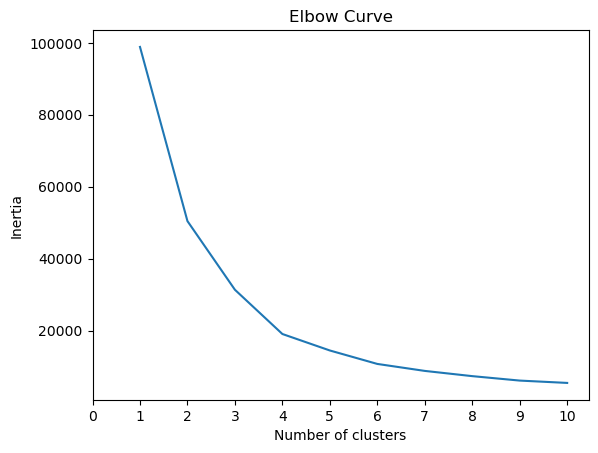

In [190]:
# Finding the best value for k
inertia = []
k = list(range(1, 11))
# k means creates clusters
# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(df_iris_pca)
    inertia.append(km.inertia_)

# Creating the Elbow Curve
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(list(range(11)))
plt.title('Elbow Curve')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [116]:
model = KMeans(n_clusters=3, random_state=42).fit(X_scaled)

In [113]:
pca = PCA(n_components=2)
pca.fit(X_scaled)
print(pca.explained_variance_ratio_)

X_pca = pca.transform(X_scaled)

[0.96613038 0.02908567]


In [114]:
df_pca = pd.DataFrame(X_pca, columns=['principal component 1','principal component 2',])

In [115]:
df_pca.hvplot.scatter(
    x="principal component 1",
    y="principal component 2",
)

:Scatter   [principal component 1]   (principal component 2)

In [117]:
y_pred = model.fit_predict(X_pca)

In [118]:
df_pca["cluster"] = y_pred
df_pca.hvplot.scatter(
    x="principal component 1",
    y="principal component 2",
    by="cluster"
)

:NdOverlay   [cluster]
   :Scatter   [principal component 1]   (principal component 2)

In [71]:
from sklearn import linear_model

In [72]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [73]:
# from sklearn.linear_model import LogisticRegression
# classifier = LogisticRegression()
# classifier

In [74]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

In [75]:
model.fit(X_train, y_train)

LinearRegression()

In [76]:
# Fit the model to the training data, and calculate the scores for the training and testing data.

### BEGIN SOLUTION
model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

### END SOLUTION 

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.9430998177633545
Testing Score: 0.9421260019599836


In [77]:
# Calculate the mean_squared_error and the r-squared value
# for the testing data

from sklearn.metrics import mean_squared_error, r2_score

### BEGIN SOLUTION

# Use our model to make predictions
predicted = model.predict(X_test)

# Score the predictions with mse and r2
mse = mean_squared_error(y_test, predicted)
r2 = r2_score(y_test, predicted)

print(f"mean squared error (MSE): {mse}")
print(f"R-squared (R2): {r2}")


mean squared error (MSE): 58594.53358284253
R-squared (R2): 0.9421260019599836


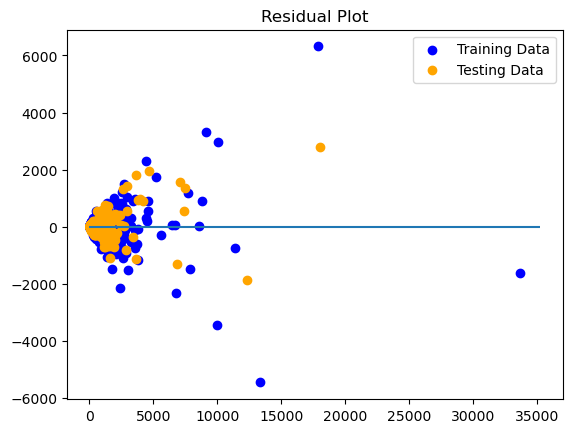

In [78]:
plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual Plot")
plt.show()

In [79]:
model.score(X_test, y_test)

0.9421260019599836

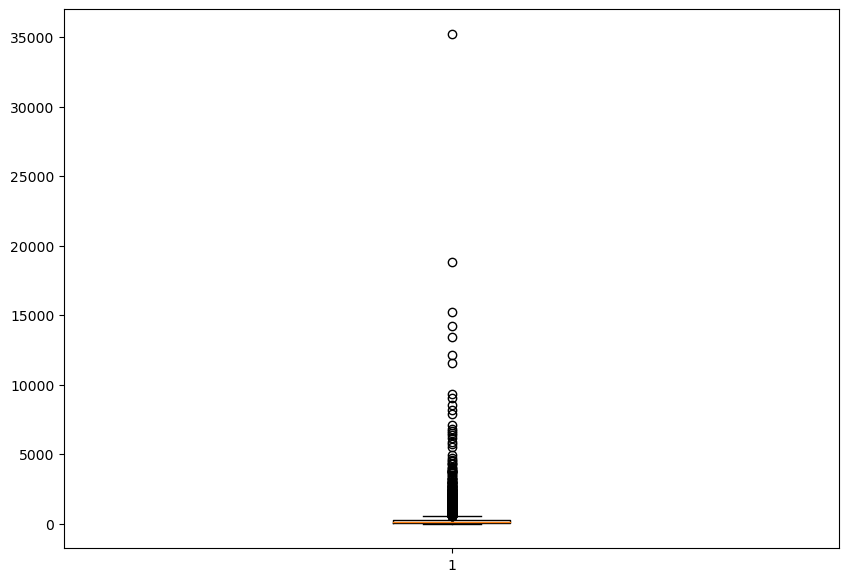

In [192]:

# Import libraries
import matplotlib.pyplot as plt
import numpy as np
 
 
# Creating dataset
np.random.seed(10)
data = df["deaths"]
 
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(data)
 
# show plot
plt.show()

In [193]:
data.describe()

count     3142.00000
mean       349.12317
std       1124.50972
min          0.00000
25%         47.00000
50%        110.00000
75%        261.00000
max      35250.00000
Name: deaths, dtype: float64